Курсовая работа

03. Регрессия для CC50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.4 MB/s eta 0:00:00


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import joblib
import optuna
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# Загрузка  данных
df_standardscaler = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Classic_ML_Vo_PJ/df_standardscaler.csv')

In [ ]:
# Выведим размерность датафрейма
df_standardscaler.shape

(969, 188)

In [ ]:
# Выведим первые строки датафрейма
df_standardscaler.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


In [ ]:
# Выбираем целевую переменную (CC50) и признаки для модели
y = df_standardscaler['CC50']  # Целевая переменная
X = df_standardscaler.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки

# Разделение данных на обучающую и тестовую выборки в соотношении 75:25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Словарь с классами регрессоров, которые будем оптимизировать
REGRESSORS = {
    'XGBRegressor': XGBRegressor,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'RandomForestRegressor': RandomForestRegressor,
    'CatBoostRegressor': CatBoostRegressor
}

def objective(trial, regressor_name):
    """Оптимизация гиперпараметров."""
    if regressor_name == 'XGBRegressor':
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBRegressor(**params)

    elif regressor_name == 'DecisionTreeRegressor':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeRegressor(**params)

    elif regressor_name == 'RandomForestRegressor':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestRegressor(**params)

    elif regressor_name == 'CatBoostRegressor':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0
        }
        model = CatBoostRegressor(**params)
    # Обучаем модель и делаем предсказания
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Оцениваем качество по метрике MSE
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Результаты лучшей модели для каждого алгоритма
best_models = {}
for regressor_name in REGRESSORS.keys():
    print(f"Оптимизация гиперпараметров для {regressor_name}...")
    study = optuna.create_study(direction='minimize')  # Минимизация MSE
    study.optimize(lambda trial: objective(trial, regressor_name), n_trials=200)
    # Получаем лучший набор параметров
    best_trial = study.best_trial
    best_model = REGRESSORS[regressor_name](**best_trial.params).fit(X_train, y_train)
    best_models[regressor_name] = {
        'best_params': best_trial.params,
        'best_model': best_model,
    }

    print(f"Оптимальные гиперпараметры для {regressor_name}:", best_trial.params)

# Оценка качества моделей на тестовых данных
for regressor_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"{regressor_name} - Тестовый MSE: {mse}, Тестовый MAE: {mae}, Тестовый R^2: {r2}")

[I 2025-06-14 13:51:49,109] A new study created in memory with name: no-name-0999eeac-91b3-4645-8dee-03f4848920c1


Оптимизация гиперпараметров для XGBRegressor...


[I 2025-06-14 13:51:56,441] Trial 0 finished with value: 0.9204603562710602 and parameters: {'learning_rate': 0.0012130850659200305, 'max_depth': 7, 'n_estimators': 175, 'subsample': 0.590958556545252, 'colsample_bytree': 0.8383411064530154}. Best is trial 0 with value: 0.9204603562710602.
[I 2025-06-14 13:51:58,337] Trial 1 finished with value: 0.5804198277763419 and parameters: {'learning_rate': 0.1641246555743414, 'max_depth': 7, 'n_estimators': 88, 'subsample': 0.9087672969731257, 'colsample_bytree': 0.9286254837910708}. Best is trial 1 with value: 0.5804198277763419.
[I 2025-06-14 13:52:03,877] Trial 2 finished with value: 0.5614642093009438 and parameters: {'learning_rate': 0.1079776184691941, 'max_depth': 11, 'n_estimators': 118, 'subsample': 0.9067304468975529, 'colsample_bytree': 0.9507351331819508}. Best is trial 2 with value: 0.5614642093009438.
[I 2025-06-14 13:52:04,910] Trial 3 finished with value: 0.9804819634360602 and parameters: {'learning_rate': 0.0005929024255004585

Оптимальные гиперпараметры для XGBRegressor: {'learning_rate': 0.005445727671833486, 'max_depth': 6, 'n_estimators': 523, 'subsample': 0.985066978850151, 'colsample_bytree': 0.693151105160994}
Оптимизация гиперпараметров для DecisionTreeRegressor...


[I 2025-06-14 14:12:08,440] Trial 5 finished with value: 0.6859276939440213 and parameters: {'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.5843293350224529.
[I 2025-06-14 14:12:08,495] Trial 6 finished with value: 0.6883891393361931 and parameters: {'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.5843293350224529.
[I 2025-06-14 14:12:08,551] Trial 7 finished with value: 0.5979733616037443 and parameters: {'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.5843293350224529.
[I 2025-06-14 14:12:08,597] Trial 8 finished with value: 0.5754608851979557 and parameters: {'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 8 with value: 0.5754608851979557.
[I 2025-06-14 14:12:08,642] Trial 9 finished with value: 0.5586629646444231 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 9 wi

Оптимальные гиперпараметры для DecisionTreeRegressor: {'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2}
Оптимизация гиперпараметров для RandomForestRegressor...


[I 2025-06-14 14:12:27,214] Trial 0 finished with value: 0.45623857809824336 and parameters: {'n_estimators': 193, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.45623857809824336.
[I 2025-06-14 14:12:31,122] Trial 1 finished with value: 0.44895251433549493 and parameters: {'n_estimators': 115, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.44895251433549493.
[I 2025-06-14 14:12:40,162] Trial 2 finished with value: 0.4550922208048251 and parameters: {'n_estimators': 310, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.44895251433549493.
[I 2025-06-14 14:12:49,643] Trial 3 finished with value: 0.4638969792766544 and parameters: {'n_estimators': 365, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.44895251433549493.
[I 2025-06-14 14:12:55,246] Trial 4 finished with value: 0.4942282593970113 and parame

Оптимальные гиперпараметры для RandomForestRegressor: {'n_estimators': 131, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 3}
Оптимизация гиперпараметров для CatBoostRegressor...


[I 2025-06-14 14:36:26,525] Trial 0 finished with value: 0.4945130831955191 and parameters: {'learning_rate': 0.06276107122466648, 'depth': 4, 'iterations': 217, 'l2_leaf_reg': 0.0018086931407603915}. Best is trial 0 with value: 0.4945130831955191.
[I 2025-06-14 14:36:27,253] Trial 1 finished with value: 0.5625556713937941 and parameters: {'learning_rate': 0.309627224869887, 'depth': 4, 'iterations': 107, 'l2_leaf_reg': 0.008155810056818666}. Best is trial 0 with value: 0.4945130831955191.
[I 2025-06-14 14:36:32,448] Trial 2 finished with value: 1.0771688684001233 and parameters: {'learning_rate': 0.00012361001851049646, 'depth': 6, 'iterations': 321, 'l2_leaf_reg': 0.00047153164143837303}. Best is trial 0 with value: 0.4945130831955191.
[I 2025-06-14 14:36:33,213] Trial 3 finished with value: 1.0716134766520444 and parameters: {'learning_rate': 0.00038728583349509105, 'depth': 3, 'iterations': 182, 'l2_leaf_reg': 0.0006063811981692764}. Best is trial 0 with value: 0.4945130831955191.


0:	learn: 0.9783613	total: 51.7ms	remaining: 25.9s
1:	learn: 0.9754298	total: 107ms	remaining: 26.7s
2:	learn: 0.9718899	total: 178ms	remaining: 29.6s
3:	learn: 0.9683714	total: 232ms	remaining: 28.9s
4:	learn: 0.9643314	total: 285ms	remaining: 28.4s
5:	learn: 0.9603457	total: 337ms	remaining: 27.9s
6:	learn: 0.9560963	total: 387ms	remaining: 27.4s
7:	learn: 0.9524969	total: 440ms	remaining: 27.2s
8:	learn: 0.9484786	total: 497ms	remaining: 27.3s
9:	learn: 0.9446057	total: 548ms	remaining: 27s
10:	learn: 0.9413201	total: 604ms	remaining: 27s
11:	learn: 0.9381419	total: 657ms	remaining: 26.9s
12:	learn: 0.9354639	total: 713ms	remaining: 26.9s
13:	learn: 0.9320444	total: 764ms	remaining: 26.7s
14:	learn: 0.9284821	total: 816ms	remaining: 26.6s
15:	learn: 0.9254539	total: 867ms	remaining: 26.4s
16:	learn: 0.9220002	total: 921ms	remaining: 26.3s
17:	learn: 0.9187761	total: 973ms	remaining: 26.2s
18:	learn: 0.9158685	total: 1.02s	remaining: 26.1s
19:	learn: 0.9122587	total: 1.08s	remaining:

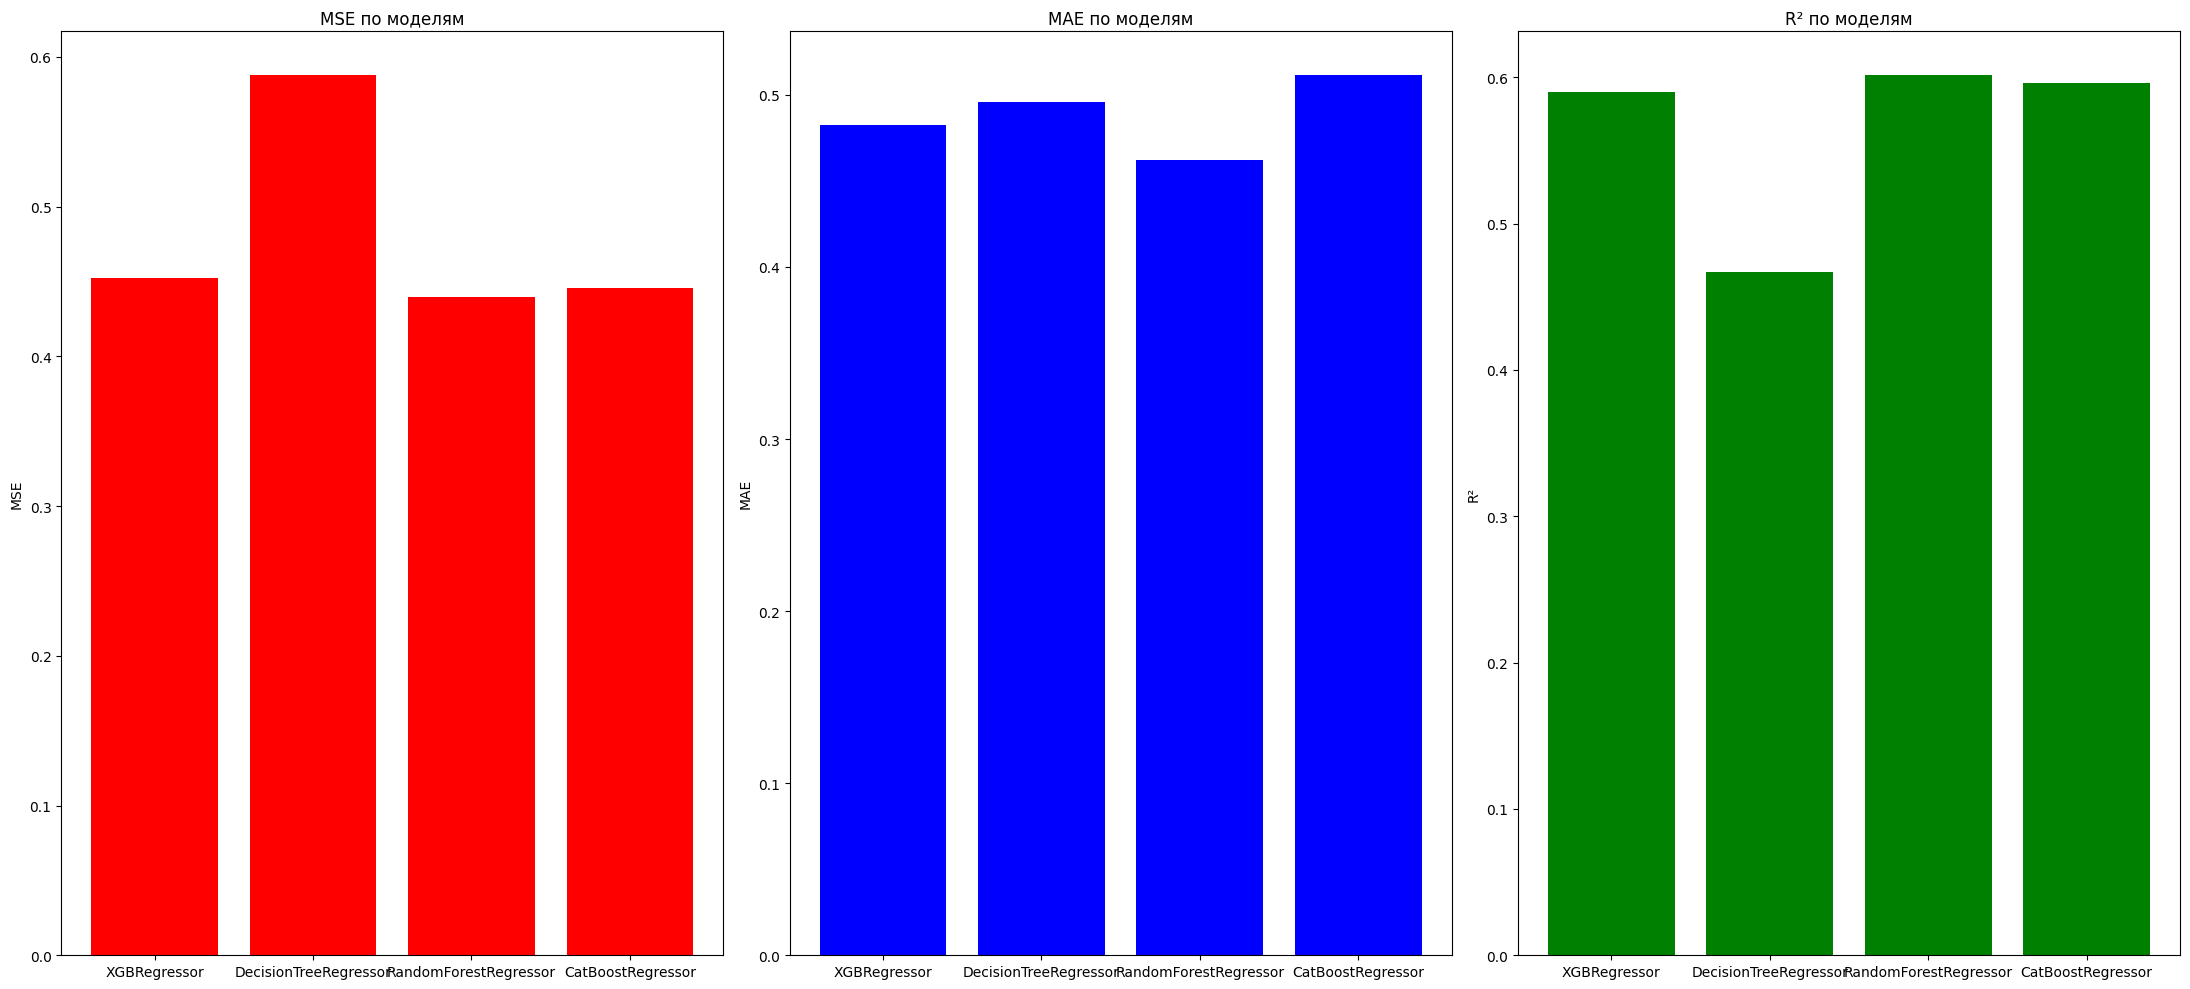

In [ ]:
# Сравненим качество регрессионных моделей с визуализацией результатов
def plot_results(models_metrics):
    model_names = list(models_metrics.keys())
    mse_values = [metrics[0] for metrics in models_metrics.values()]
    mae_values = [metrics[1] for metrics in models_metrics.values()]
    r2_values = [metrics[2] for metrics in models_metrics.values()]

    plt.figure(figsize=(22, 10))

    # График 1: MSE по моделям
    plt.subplot(1, 3, 1)
    plt.bar(model_names, mse_values, color='red')
    plt.title('MSE по моделям')
    plt.ylabel('MSE')

    # График 2: MAE по моделям
    plt.subplot(1, 3, 2)
    plt.bar(model_names, mae_values, color='blue')
    plt.title('MAE по моделям')
    plt.ylabel('MAE')

    # График 3: R² по моделям
    plt.subplot(1, 3, 3)
    plt.bar(model_names, r2_values, color='green')
    plt.title('R² по моделям')
    plt.ylabel('R²')

    plt.tight_layout()
    plt.show()

# Создадим словарь с метриками для каждой модели
metrics_dict = {name: (mse, mae, r2) for name, (mse, mae, r2) in zip(best_models.keys(), [(mean_squared_error(y_test, model_data['best_model'].predict(X_test)),
                       mean_absolute_error(y_test, model_data['best_model'].predict(X_test)),
                       r2_score(y_test, model_data['best_model'].predict(X_test)) ) for model_data in best_models.values()])}

plot_results(metrics_dict)

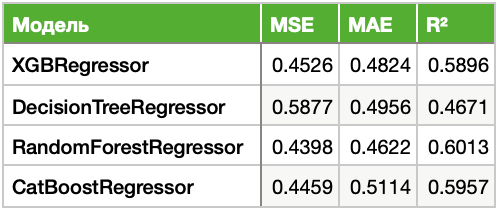


1. RandomForestRegressor показывает наилучшие результаты, меет минимальное значение MSE, наименьшую ошибку предсказания.

Также имеет лучший R², эта модель лучше всего объясняет вариацию целевой переменной CC50.

RandomForestRegressor — лучшая модель по метрикам качества среди всех рассмотренных.

2. XGBoost и RandomForestRegressor конкурируют в тестах.
Обе модели имеют очень близкие значения MSE и R².
Разница между ними незначительна, особенно учитывая стабильность Random Forest.

XGBoost и RandomForestRegressor являются сопоставимыми по качеству.

3. CatBoostRegressor демонстрирует средние результаты.
У CatBoostRegressor среднее значение MSE и немного худший R² по сравнению с RandomForestRegressor.

MAE у CatBoostRegressor даже ниже, чем у остальных моделей.

CatBoostRegressor имеет хорошие, результаты.

4. DecisionTreeRegressor хуже остальных моделей.
Имеет самое высокое значение MSE и MAE, и самый низкий R².

DecisionTreeRegressor не рекомендуется использовать как основную модель в данной задаче.

Заключение:

Модель RandomForestRegressor показала себя лучше всего по всем ключевым метрикам, поэтому используем RandomForestRegressor как основную модель для дальнейших предсказаний.

In [ ]:
import pickle
# Цикл для сохранения обученных моделей в файлы формата .pkl
for regressor_name, model_data in best_models.items():
    # Формируем имя файла на основе названия модели и целевой переменной (CC50)
    filename = f"{regressor_name}_CC50.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model_data['best_model'], file)
        print(f"Модель '{filename}' сохранена.")

# Загрузка модели из созданного pickle файла
def load_model(regressor_name):
    # Формируем имя файла на основе названия модели и целевой переменной
    filename = f"{regressor_name}_CC50.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

# Загрузка сохранённых моделей
loaded_xgb = load_model('XGBRegressor')           # XGBoost модель
loaded_dt = load_model('DecisionTreeRegressor')   # Дерево решений
loaded_rf = load_model('RandomForestRegressor')   # Случайный лес
loaded_catboost = load_model('CatBoostRegressor') # CatBoost модель

Модель 'XGBRegressor_CC50.pkl' сохранена.
Модель 'DecisionTreeRegressor_CC50.pkl' сохранена.
Модель 'RandomForestRegressor_CC50.pkl' сохранена.
Модель 'CatBoostRegressor_CC50.pkl' сохранена.


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Словарь с загруженными моделями
loaded_models = {
    'XGBRegressor': loaded_xgb,
    'DecisionTreeRegressor': loaded_dt,
    'RandomForestRegressor': loaded_rf,
    'CatBoostRegressor': loaded_catboost
}

# Проверка всех загруженных моделей
for regressor_name, model in loaded_models.items():
    y_test_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"{regressor_name} - Тестовые метрики после загрузки:")
    print(f"  MSE: {mse:.4f}")
    print(f"  R²: {r2:.4f}\n")

XGBRegressor - Тестовые метрики после загрузки:
  MSE: 0.4526
  R²: 0.5896

DecisionTreeRegressor - Тестовые метрики после загрузки:
  MSE: 0.5877
  R²: 0.4671

RandomForestRegressor - Тестовые метрики после загрузки:
  MSE: 0.4398
  R²: 0.6013

CatBoostRegressor - Тестовые метрики после загрузки:
  MSE: 0.4459
  R²: 0.5957



In [ ]:
import os
# Проверяем все файлы в текущей директории
os.listdir()

['.config',
 'CatBoostRegressor_CC50.pkl',
 'DecisionTreeRegressor_CC50.pkl',
 'XGBRegressor_CC50.pkl',
 'RandomForestRegressor_CC50.pkl',
 'catboost_info',
 'drive',
 'sample_data']